# Testing Alternative Resistance Scaling Methods

## Creating Resistance Rasters

In [1]:
import numpy as np
import rasterio
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# Path to the fixed land cover raster
fixed_raster_path = "C:/GIS_Course/MScThesis-MaviSantarelli/data/LandCover/LandCover_Fixed.tif"

# Load the raster
with rasterio.open(fixed_raster_path) as src:
    landcover_data = src.read(1)  # Read raster data as a 2D NumPy array
    meta = src.meta.copy()  # Store metadata for saving later
    nodata_value = src.nodata  # Store NoData value


In [3]:
# Load land cover reference table (maps VALUE to EUNIS codes)
reference_path = "C:/GIS_Course/MScThesis-MaviSantarelli/data/LandCover/reference.csv"
df_reference = pd.read_csv(reference_path)

# Load EUNIS resistance table (EUNIS code to species suitability)
eunis_file = "C:/GIS_Course/MScThesis-MaviSantarelli/data/LandCover/mavi_data.csv"
df_reclass = pd.read_csv(eunis_file, skiprows=1)
df_reclass.columns = ["EUNIS_Code", "EUNIS_Description", "Bufo_bufo_Suitability", 
                      "Rana_temporaria_Suitability", "Lissotriton_helveticus_Suitability"]


In [4]:
# Convert suitability values to numeric
cols_to_convert = ["Bufo_bufo_Suitability", "Rana_temporaria_Suitability", "Lissotriton_helveticus_Suitability"]
df_reclass[cols_to_convert] = df_reclass[cols_to_convert].apply(pd.to_numeric, errors="coerce")


### Apply Resistance Scaling Methods

#### (A) Linear Scaling

In [24]:
df_reclass["Linear_Bufo"] = (df_reclass["Bufo_bufo_Suitability"].max() - df_reclass["Bufo_bufo_Suitability"]) / \
                            (df_reclass["Bufo_bufo_Suitability"].max() - df_reclass["Bufo_bufo_Suitability"].min()) * 100
df_reclass["Linear_Rana"] = (df_reclass["Rana_temporaria_Suitability"].max() - df_reclass["Rana_temporaria_Suitability"]) / \
                            (df_reclass["Rana_temporaria_Suitability"].max() - df_reclass["Rana_temporaria_Suitability"].min()) * 100
df_reclass["Linear_Lissotriton"] = (df_reclass["Lissotriton_helveticus_Suitability"].max() - df_reclass["Lissotriton_helveticus_Suitability"]) / \
                            (df_reclass["Lissotriton_helveticus_Suitability"].max() - df_reclass["Lissotriton_helveticus_Suitability"].min()) * 100


#### (B) Exponential Scaling

In [25]:
df_reclass["Exponential_Bufo"] = np.exp(11 - df_reclass["Bufo_bufo_Suitability"])  # Already correctly mapped
df_reclass["Exponential_Rana"] = np.exp(11 - df_reclass["Rana_temporaria_Suitability"])
df_reclass["Exponential_Lissotriton"] = np.exp(11 - df_reclass["Lissotriton_helveticus_Suitability"])

# Normalize Exponential Scaling to 1-1000 range
for species in ["Bufo", "Rana", "Lissotriton"]:
    max_value = df_reclass[f"Exponential_{species}"].max()
    df_reclass[f"Exponential_{species}"] = (df_reclass[f"Exponential_{species}"] / max_value) * 1000


#### (C) Categorical Scaling

In [26]:
df_reclass["Categorical_Bufo"] = pd.cut(df_reclass["Bufo_bufo_Suitability"], bins=[0, 3, 6, 8, 10, 11],
                                         labels=[1000, 500, 200, 100, 10])  # Lower suitability = higher resistance
df_reclass["Categorical_Rana"] = pd.cut(df_reclass["Rana_temporaria_Suitability"], bins=[0, 3, 6, 8, 10, 11],
                                         labels=[1000, 500, 200, 100, 10])
df_reclass["Categorical_Lissotriton"] = pd.cut(df_reclass["Lissotriton_helveticus_Suitability"], bins=[0, 3, 6, 8, 10, 11],
                                         labels=[1000, 500, 200, 100, 10])

### Create Mapping Dictionaries

In [27]:
# Mapping EUNIS codes to resistance values for each species
eunis_to_linear = dict(zip(df_reclass["EUNIS_Code"], df_reclass["Linear_Bufo"]))
eunis_to_exponential = dict(zip(df_reclass["EUNIS_Code"], df_reclass["Exponential_Bufo"]))
eunis_to_categorical = dict(zip(df_reclass["EUNIS_Code"], df_reclass["Categorical_Bufo"]))

eunis_to_linear_rana = dict(zip(df_reclass["EUNIS_Code"], df_reclass["Linear_Rana"]))
eunis_to_exponential_rana = dict(zip(df_reclass["EUNIS_Code"], df_reclass["Exponential_Rana"]))
eunis_to_categorical_rana = dict(zip(df_reclass["EUNIS_Code"], df_reclass["Categorical_Rana"]))

eunis_to_linear_lissotriton = dict(zip(df_reclass["EUNIS_Code"], df_reclass["Linear_Lissotriton"]))
eunis_to_exponential_lissotriton = dict(zip(df_reclass["EUNIS_Code"], df_reclass["Exponential_Lissotriton"]))
eunis_to_categorical_lissotriton = dict(zip(df_reclass["EUNIS_Code"], df_reclass["Categorical_Lissotriton"]))

# Mapping raster values (1-28) to EUNIS codes
value_to_eunis = dict(zip(df_reference["VALUE"], df_reference["EUNIS_CODE"]))

# Mapping raster values (1-28) directly to resistance values
value_to_linear = {val: eunis_to_linear.get(eunis, np.nan) for val, eunis in value_to_eunis.items()}
value_to_exponential = {val: eunis_to_exponential.get(eunis, np.nan) for val, eunis in value_to_eunis.items()}
value_to_categorical = {val: eunis_to_categorical.get(eunis, np.nan) for val, eunis in value_to_eunis.items()}

value_to_linear_rana = {val: eunis_to_linear_rana.get(eunis, np.nan) for val, eunis in value_to_eunis.items()}
value_to_exponential_rana = {val: eunis_to_exponential_rana.get(eunis, np.nan) for val, eunis in value_to_eunis.items()}
value_to_categorical_rana = {val: eunis_to_categorical_rana.get(eunis, np.nan) for val, eunis in value_to_eunis.items()}

value_to_linear_lissotriton = {val: eunis_to_linear_lissotriton.get(eunis, np.nan) for val, eunis in value_to_eunis.items()}
value_to_exponential_lissotriton = {val: eunis_to_exponential_lissotriton.get(eunis, np.nan) for val, eunis in value_to_eunis.items()}
value_to_categorical_lissotriton = {val: eunis_to_categorical_lissotriton.get(eunis, np.nan) for val, eunis in value_to_eunis.items()}


### Apply Resistance Mapping to Rasters

In [28]:
# Define a default resistance value for unmapped land cover types
DEFAULT_RESISTANCE = 1000  # High resistance for unmapped areas

# Create empty arrays for resistance rasters
resistance_linear = np.copy(landcover_data)
resistance_exponential = np.copy(landcover_data)
resistance_categorical = np.copy(landcover_data)

resistance_linear_rana = np.copy(landcover_data)
resistance_exponential_rana = np.copy(landcover_data)
resistance_categorical_rana = np.copy(landcover_data)

resistance_linear_lissotriton = np.copy(landcover_data)
resistance_exponential_lissotriton = np.copy(landcover_data)
resistance_categorical_lissotriton = np.copy(landcover_data)

# Handle NoData values FIRST (avoid modifying them)
for resistance_map in [resistance_linear, resistance_exponential, resistance_categorical,
                       resistance_linear_rana, resistance_exponential_rana, resistance_categorical_rana,
                       resistance_linear_lissotriton, resistance_exponential_lissotriton, resistance_categorical_lissotriton]:
    resistance_map[landcover_data == -32768] = -32768  # Preserve NoData
    resistance_map[landcover_data == 0] = -32768  # Treat 0 as NoData

# Apply resistance mapping while skipping NoData and zero values
for val in np.unique(landcover_data):
    if val in [-32768, 0]:  # Skip NoData and 0 values explicitly
        continue

    # Assign resistance values, using DEFAULT_RESISTANCE if NaN
    resistance_linear[landcover_data == val] = value_to_linear.get(val, DEFAULT_RESISTANCE)
    resistance_exponential[landcover_data == val] = value_to_exponential.get(val, DEFAULT_RESISTANCE)
    resistance_categorical[landcover_data == val] = value_to_categorical.get(val, DEFAULT_RESISTANCE)

    resistance_linear_rana[landcover_data == val] = value_to_linear_rana.get(val, DEFAULT_RESISTANCE)
    resistance_exponential_rana[landcover_data == val] = value_to_exponential_rana.get(val, DEFAULT_RESISTANCE)
    resistance_categorical_rana[landcover_data == val] = value_to_categorical_rana.get(val, DEFAULT_RESISTANCE)

    resistance_linear_lissotriton[landcover_data == val] = value_to_linear_lissotriton.get(val, DEFAULT_RESISTANCE)
    resistance_exponential_lissotriton[landcover_data == val] = value_to_exponential_lissotriton.get(val, DEFAULT_RESISTANCE)
    resistance_categorical_lissotriton[landcover_data == val] = value_to_categorical_lissotriton.get(val, DEFAULT_RESISTANCE)

print("✅ Successfully applied resistance values while skipping NoData (-32768) and zero values.")


✅ Successfully applied resistance values while skipping NoData (-32768) and zero values.


### Save Resistance Rasters

In [31]:
# Define output paths
output_paths = {
    "Linear_Bufo": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Linear_Bufo.tif",
    "Exponential_Bufo": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Bufo.tif",
    "Categorical_Bufo": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Bufo.tif",
    "Linear_Rana": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Linear_Rana.tif",
    "Exponential_Rana": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Rana.tif",
    "Categorical_Rana": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Rana.tif",
    "Linear_Lissotriton": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Linear_Lissotriton.tif",
    "Exponential_Lissotriton": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Lissotriton.tif",
    "Categorical_Lissotriton": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Lissotriton.tif"
}

# Explicitly map dictionary keys to variable names
resistance_maps = {
    "Linear_Bufo": resistance_linear,
    "Exponential_Bufo": resistance_exponential,
    "Categorical_Bufo": resistance_categorical,
    "Linear_Rana": resistance_linear_rana,
    "Exponential_Rana": resistance_exponential_rana,
    "Categorical_Rana": resistance_categorical_rana,
    "Linear_Lissotriton": resistance_linear_lissotriton,
    "Exponential_Lissotriton": resistance_exponential_lissotriton,
    "Categorical_Lissotriton": resistance_categorical_lissotriton
}

# Save resistance rasters
for method, path in output_paths.items():
    meta.update(dtype=rasterio.float32)  # Ensure correct data format
    with rasterio.open(path, "w", **meta) as dst:
        dst.write(resistance_maps[method].astype(np.float32), 1)  # Directly access the correct variable
    print(f"✅ {method} Resistance Raster saved at: {path}")


✅ Linear_Bufo Resistance Raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Linear_Bufo.tif
✅ Exponential_Bufo Resistance Raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Bufo.tif
✅ Categorical_Bufo Resistance Raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Bufo.tif
✅ Linear_Rana Resistance Raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Linear_Rana.tif
✅ Exponential_Rana Resistance Raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Rana.tif
✅ Categorical_Rana Resistance Raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Rana.tif
✅ Linear_Lissotriton Resistance Raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Linear_Lissotriton.tif
✅ Exponential_Lissotriton Resistance Raster saved at: C:/

### Visualize the Resistance Rasters

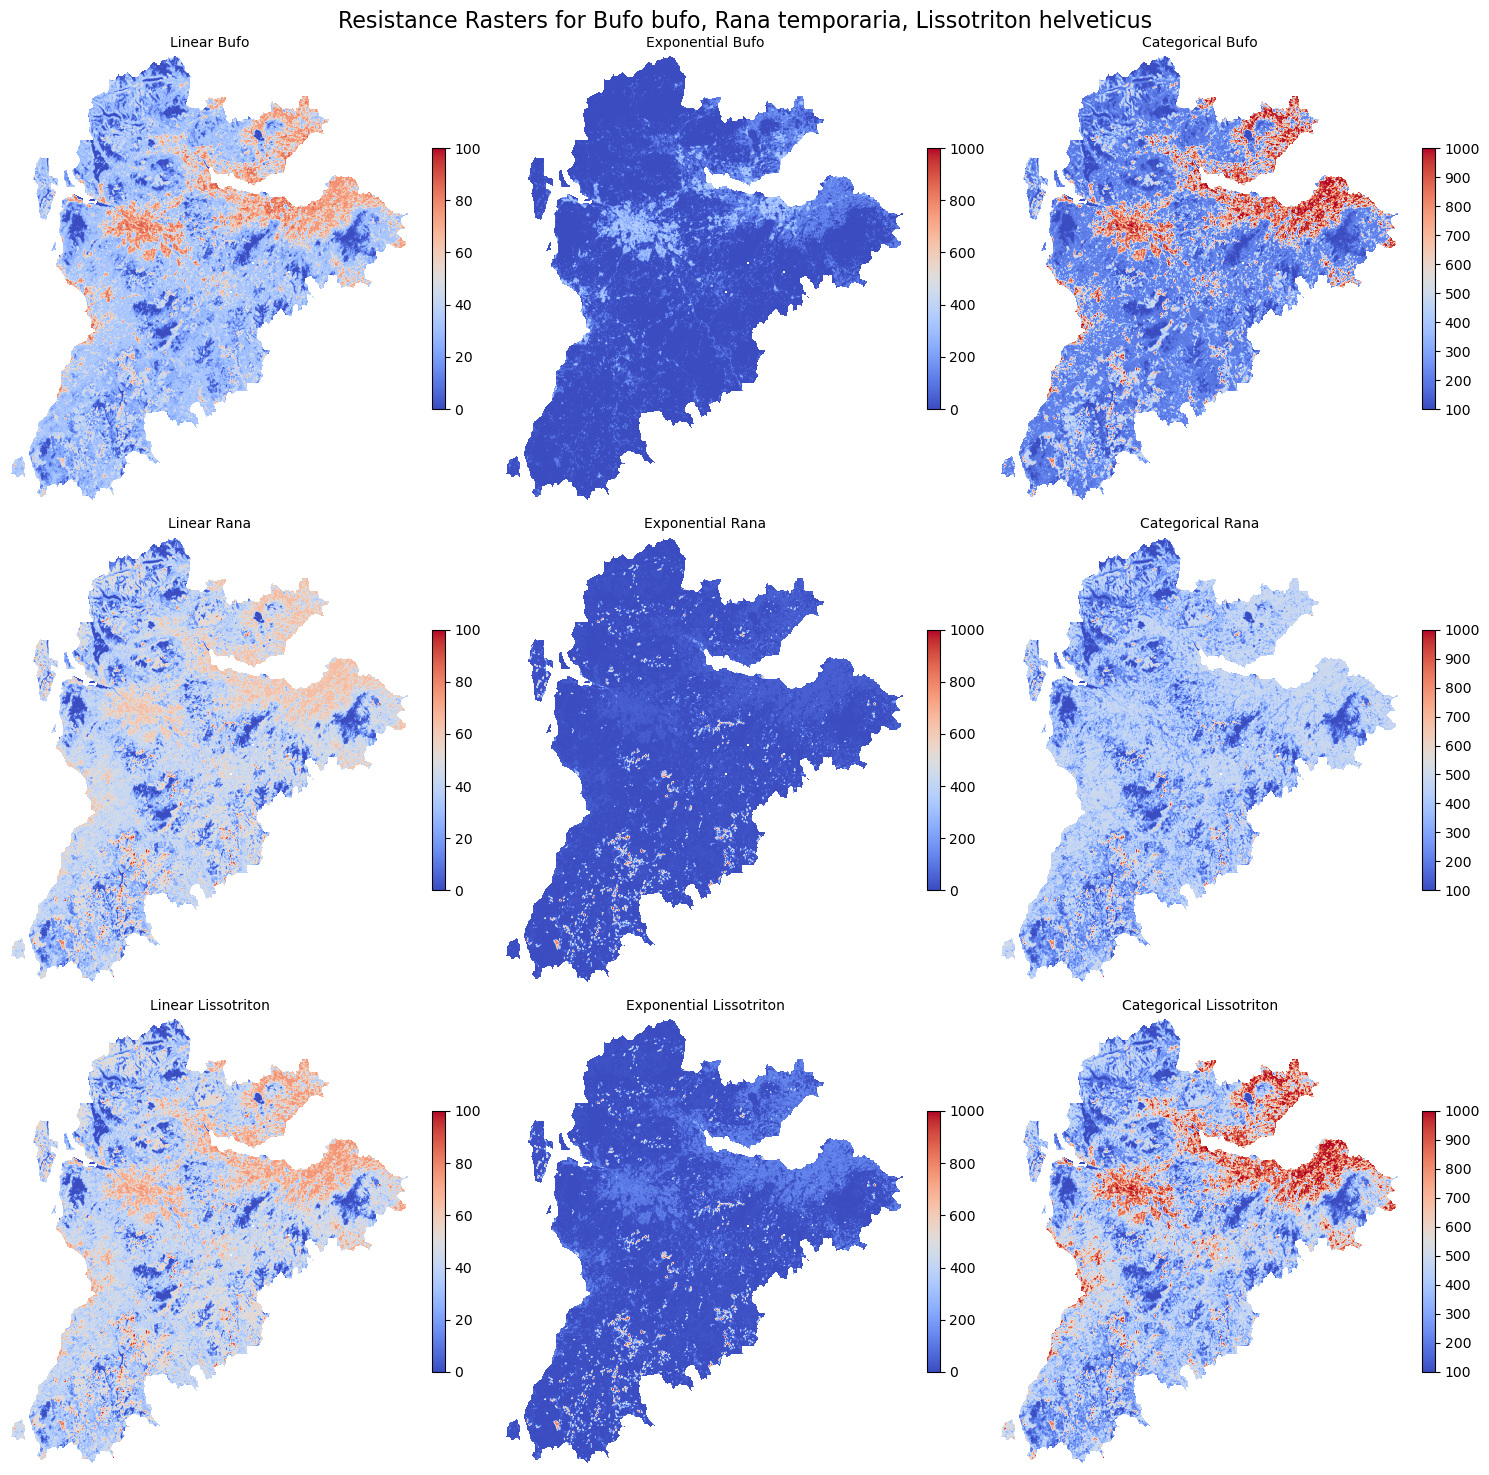

In [32]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Define paths to saved resistance rasters
resistance_paths = {
    "Linear_Bufo": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Linear_Bufo.tif",
    "Exponential_Bufo": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Bufo.tif",
    "Categorical_Bufo": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Bufo.tif",
    "Linear_Rana": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Linear_Rana.tif",
    "Exponential_Rana": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Rana.tif",
    "Categorical_Rana": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Rana.tif",
    "Linear_Lissotriton": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Linear_Lissotriton.tif",
    "Exponential_Lissotriton": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Lissotriton.tif",
    "Categorical_Lissotriton": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Lissotriton.tif"
}

# Set up the figure size
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
fig.suptitle("Resistance Rasters for Bufo bufo, Rana temporaria, Lissotriton helveticus", fontsize=16)

# Loop through raster files and plot them
for ax, (title, path) in zip(axes.flat, resistance_paths.items()):
    with rasterio.open(path) as src:
        data = src.read(1)  # Read raster band
        nodata_value = src.nodata
        # Mask NoData values
        data_masked = np.ma.masked_where(data == nodata_value, data)

    # Plot raster
    im = ax.imshow(data_masked, cmap="coolwarm", aspect='auto')
    ax.set_title(title.replace("_", " "), fontsize=10)
    ax.axis("off")
    plt.colorbar(im, ax=ax, fraction=0.03)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Make room for title
plt.show()


### Adjustments 1

In [33]:
import numpy as np

# Adjusted Exponential Scaling (Reduces Extreme Values)
df_reclass["Exponential_Bufo"] = np.exp((11 - df_reclass["Bufo_bufo_Suitability"]) / 2)  # Divide by 2 to reduce steepness
df_reclass["Exponential_Rana"] = np.exp((11 - df_reclass["Rana_temporaria_Suitability"]) / 2)
df_reclass["Exponential_Lissotriton"] = np.exp((11 - df_reclass["Lissotriton_helveticus_Suitability"]) / 2)

# Normalize to a 1-1000 range
for species in ["Bufo", "Rana", "Lissotriton"]:
    max_value = df_reclass[f"Exponential_{species}"].max()
    df_reclass[f"Exponential_{species}"] = (df_reclass[f"Exponential_{species}"] / max_value) * 1000

print("✅ Exponential Scaling Adjusted and Normalized")


✅ Exponential Scaling Adjusted and Normalized


In [34]:
# Adjusted Categorical Scaling (Smoother Transitions)
df_reclass["Categorical_Bufo"] = pd.cut(df_reclass["Bufo_bufo_Suitability"], bins=[0, 3, 6, 8, 10, 11],
                                         labels=[900, 700, 500, 300, 100])  # More gradual decrease
df_reclass["Categorical_Rana"] = pd.cut(df_reclass["Rana_temporaria_Suitability"], bins=[0, 3, 6, 8, 10, 11],
                                         labels=[900, 700, 500, 300, 100])
df_reclass["Categorical_Lissotriton"] = pd.cut(df_reclass["Lissotriton_helveticus_Suitability"], bins=[0, 3, 6, 8, 10, 11],
                                         labels=[900, 700, 500, 300, 100])

print("✅ Categorical Scaling Adjusted")


✅ Categorical Scaling Adjusted


In [38]:
import rasterio
import numpy as np

# Define output paths for adjusted resistance rasters
adjusted_output_paths = {
    "Exponential_Bufo": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Bufo_Adjusted.tif",
    "Exponential_Rana": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Rana_Adjusted.tif",
    "Exponential_Lissotriton": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Lissotriton_Adjusted.tif",
    "Categorical_Bufo": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Bufo_Adjusted.tif",
    "Categorical_Rana": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Rana_Adjusted.tif",
    "Categorical_Lissotriton": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Lissotriton_Adjusted.tif"
}

# Create resistance rasters with the same shape as landcover_data
resistance_rasters = {
    "Exponential_Bufo": np.full(landcover_data.shape, np.nan),
    "Exponential_Rana": np.full(landcover_data.shape, np.nan),
    "Exponential_Lissotriton": np.full(landcover_data.shape, np.nan),
    "Categorical_Bufo": np.full(landcover_data.shape, np.nan),
    "Categorical_Rana": np.full(landcover_data.shape, np.nan),
    "Categorical_Lissotriton": np.full(landcover_data.shape, np.nan)
}

# Map raster land cover values to resistance values using df_reclass
for val in np.unique(landcover_data):
    if val in value_to_eunis:
        eunis_code = value_to_eunis[val]  # Convert raster value to EUNIS Code
        if eunis_code in df_reclass["EUNIS_Code"].values:
            resistance_rasters["Exponential_Bufo"][landcover_data == val] = df_reclass.loc[df_reclass["EUNIS_Code"] == eunis_code, "Exponential_Bufo"].values[0]
            resistance_rasters["Exponential_Rana"][landcover_data == val] = df_reclass.loc[df_reclass["EUNIS_Code"] == eunis_code, "Exponential_Rana"].values[0]
            resistance_rasters["Exponential_Lissotriton"][landcover_data == val] = df_reclass.loc[df_reclass["EUNIS_Code"] == eunis_code, "Exponential_Lissotriton"].values[0]
            resistance_rasters["Categorical_Bufo"][landcover_data == val] = df_reclass.loc[df_reclass["EUNIS_Code"] == eunis_code, "Categorical_Bufo"].values[0]
            resistance_rasters["Categorical_Rana"][landcover_data == val] = df_reclass.loc[df_reclass["EUNIS_Code"] == eunis_code, "Categorical_Rana"].values[0]
            resistance_rasters["Categorical_Lissotriton"][landcover_data == val] = df_reclass.loc[df_reclass["EUNIS_Code"] == eunis_code, "Categorical_Lissotriton"].values[0]

print("✅ Resistance rasters mapped successfully to land cover values.")


✅ Resistance rasters mapped successfully to land cover values.


In [39]:
# Save the new resistance rasters
for method, path in adjusted_output_paths.items():
    meta.update(dtype=rasterio.float32)  # Ensure correct data format
    with rasterio.open(path, "w", **meta) as dst:
        dst.write(resistance_rasters[method].astype(np.float32), 1)

    print(f"✅ {method} Resistance Raster (Adjusted) saved at: {path}")


✅ Exponential_Bufo Resistance Raster (Adjusted) saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Bufo_Adjusted.tif
✅ Exponential_Rana Resistance Raster (Adjusted) saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Rana_Adjusted.tif
✅ Exponential_Lissotriton Resistance Raster (Adjusted) saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Lissotriton_Adjusted.tif
✅ Categorical_Bufo Resistance Raster (Adjusted) saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Bufo_Adjusted.tif
✅ Categorical_Rana Resistance Raster (Adjusted) saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Rana_Adjusted.tif
✅ Categorical_Lissotriton Resistance Raster (Adjusted) saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Lissotriton_Adjusted.tif


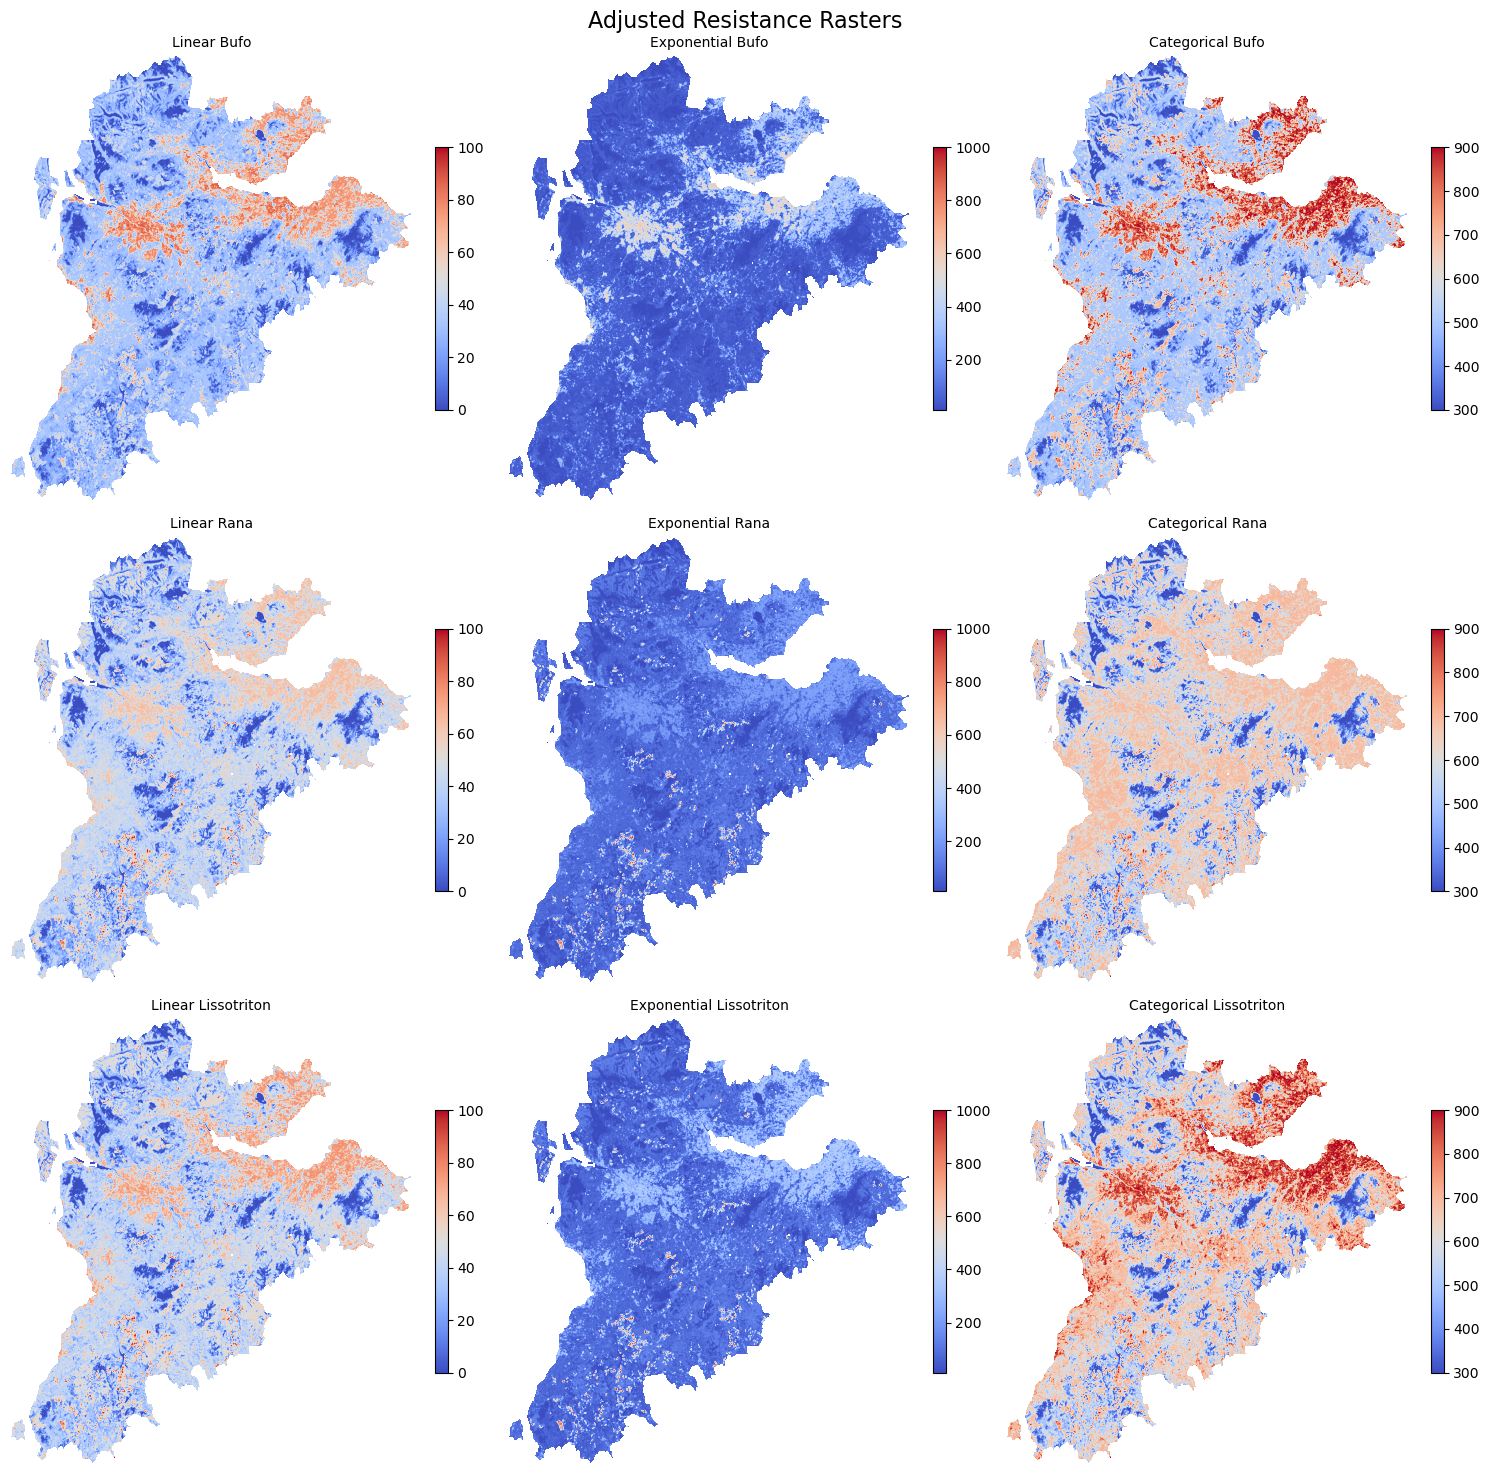

In [40]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Define paths to saved adjusted resistance rasters
adjusted_resistance_paths = {
    "Linear_Bufo": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Linear_Bufo.tif",
    "Exponential_Bufo": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Bufo_Adjusted.tif",
    "Categorical_Bufo": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Bufo_Adjusted.tif",
    "Linear_Rana": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Linear_Rana.tif",
    "Exponential_Rana": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Rana_Adjusted.tif",
    "Categorical_Rana": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Rana_Adjusted.tif",
    "Linear_Lissotriton": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Linear_Lissotriton.tif",
    "Exponential_Lissotriton": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Lissotriton_Adjusted.tif",
    "Categorical_Lissotriton": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Lissotriton_Adjusted.tif"
}

# Set up the figure size
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
fig.suptitle("Adjusted Resistance Rasters", fontsize=16)

# Loop through raster files and plot them
for ax, (title, path) in zip(axes.flat, adjusted_resistance_paths.items()):
    with rasterio.open(path) as src:
        data = src.read(1)  # Read raster band
        nodata_value = src.nodata
        # Mask NoData values
        data_masked = np.ma.masked_where(data == nodata_value, data)

    # Plot raster
    im = ax.imshow(data_masked, cmap="coolwarm", aspect='auto')
    ax.set_title(title.replace("_", " "), fontsize=10)
    ax.axis("off")
    plt.colorbar(im, ax=ax, fraction=0.03)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Make room for title
plt.show()


### Adjustments 2

In [41]:
import numpy as np

# Final adjustment to Exponential Scaling
df_reclass["Exponential_Bufo"] = np.exp((11 - df_reclass["Bufo_bufo_Suitability"]) / 1.5)
df_reclass["Exponential_Rana"] = np.exp((11 - df_reclass["Rana_temporaria_Suitability"]) / 1.5)
df_reclass["Exponential_Lissotriton"] = np.exp((11 - df_reclass["Lissotriton_helveticus_Suitability"]) / 1.5)

# Normalize to a 1-1000 range
for species in ["Bufo", "Rana", "Lissotriton"]:
    max_value = df_reclass[f"Exponential_{species}"].max()
    df_reclass[f"Exponential_{species}"] = (df_reclass[f"Exponential_{species}"] / max_value) * 1000

print("✅ Final Exponential Scaling Adjusted and Normalized")


✅ Final Exponential Scaling Adjusted and Normalized


In [42]:
# Final adjustment to Categorical Scaling (less extreme jumps)
df_reclass["Categorical_Bufo"] = pd.cut(df_reclass["Bufo_bufo_Suitability"], bins=[0, 3, 6, 8, 10, 11],
                                         labels=[750, 600, 450, 300, 150])  # Reduced highest value
df_reclass["Categorical_Rana"] = pd.cut(df_reclass["Rana_temporaria_Suitability"], bins=[0, 3, 6, 8, 10, 11],
                                         labels=[750, 600, 450, 300, 150])
df_reclass["Categorical_Lissotriton"] = pd.cut(df_reclass["Lissotriton_helveticus_Suitability"], bins=[0, 3, 6, 8, 10, 11],
                                         labels=[750, 600, 450, 300, 150])

print("✅ Final Categorical Scaling Adjusted")


✅ Final Categorical Scaling Adjusted


In [43]:
# Update resistance rasters with the final adjustments
resistance_rasters["Exponential_Bufo"] = np.full(landcover_data.shape, np.nan)
resistance_rasters["Exponential_Rana"] = np.full(landcover_data.shape, np.nan)
resistance_rasters["Exponential_Lissotriton"] = np.full(landcover_data.shape, np.nan)
resistance_rasters["Categorical_Bufo"] = np.full(landcover_data.shape, np.nan)
resistance_rasters["Categorical_Rana"] = np.full(landcover_data.shape, np.nan)
resistance_rasters["Categorical_Lissotriton"] = np.full(landcover_data.shape, np.nan)

# Map raster land cover values to updated resistance values
for val in np.unique(landcover_data):
    if val in value_to_eunis:
        eunis_code = value_to_eunis[val]  # Convert raster value to EUNIS Code
        if eunis_code in df_reclass["EUNIS_Code"].values:
            resistance_rasters["Exponential_Bufo"][landcover_data == val] = df_reclass.loc[df_reclass["EUNIS_Code"] == eunis_code, "Exponential_Bufo"].values[0]
            resistance_rasters["Exponential_Rana"][landcover_data == val] = df_reclass.loc[df_reclass["EUNIS_Code"] == eunis_code, "Exponential_Rana"].values[0]
            resistance_rasters["Exponential_Lissotriton"][landcover_data == val] = df_reclass.loc[df_reclass["EUNIS_Code"] == eunis_code, "Exponential_Lissotriton"].values[0]
            resistance_rasters["Categorical_Bufo"][landcover_data == val] = df_reclass.loc[df_reclass["EUNIS_Code"] == eunis_code, "Categorical_Bufo"].values[0]
            resistance_rasters["Categorical_Rana"][landcover_data == val] = df_reclass.loc[df_reclass["EUNIS_Code"] == eunis_code, "Categorical_Rana"].values[0]
            resistance_rasters["Categorical_Lissotriton"][landcover_data == val] = df_reclass.loc[df_reclass["EUNIS_Code"] == eunis_code, "Categorical_Lissotriton"].values[0]

print("✅ Final resistance rasters mapped successfully to land cover values.")


✅ Final resistance rasters mapped successfully to land cover values.


In [44]:
# Save the final adjusted resistance rasters
for method, path in adjusted_output_paths.items():
    meta.update(dtype=rasterio.float32)  # Ensure correct data format
    with rasterio.open(path, "w", **meta) as dst:
        dst.write(resistance_rasters[method].astype(np.float32), 1)

    print(f"✅ {method} Final Resistance Raster saved at: {path}")


✅ Exponential_Bufo Final Resistance Raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Bufo_Adjusted.tif
✅ Exponential_Rana Final Resistance Raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Rana_Adjusted.tif
✅ Exponential_Lissotriton Final Resistance Raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Exponential_Lissotriton_Adjusted.tif
✅ Categorical_Bufo Final Resistance Raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Bufo_Adjusted.tif
✅ Categorical_Rana Final Resistance Raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Rana_Adjusted.tif
✅ Categorical_Lissotriton Final Resistance Raster saved at: C:/GIS_Course/MScThesis-MaviSantarelli/results/Resistance/Resistance_Categorical_Lissotriton_Adjusted.tif


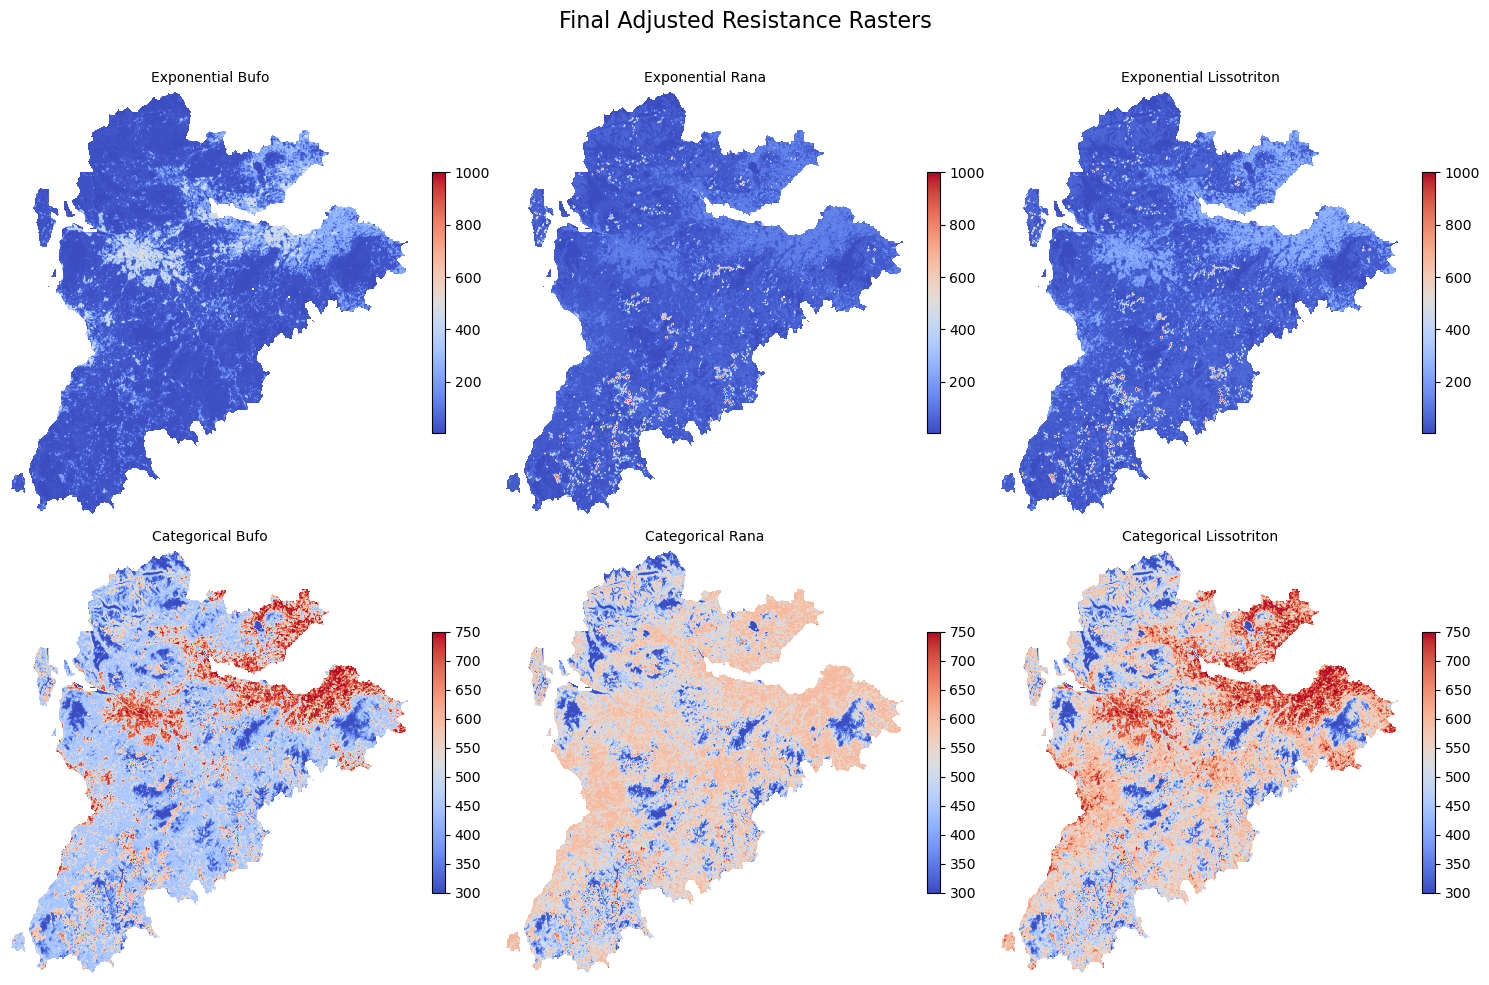

In [45]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Set up the figure size
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle("Final Adjusted Resistance Rasters", fontsize=16)

# Loop through final adjusted rasters and plot them
for ax, (title, path) in zip(axes.flat, adjusted_output_paths.items()):
    with rasterio.open(path) as src:
        data = src.read(1)  # Read raster band
        nodata_value = src.nodata
        data_masked = np.ma.masked_where(data == nodata_value, data)  # Mask NoData values

    # Plot raster
    im = ax.imshow(data_masked, cmap="coolwarm", aspect='auto')
    ax.set_title(title.replace("_", " "), fontsize=10)
    ax.axis("off")
    plt.colorbar(im, ax=ax, fraction=0.03)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.90)  # Make room for title
plt.show()
